In [1]:
%run startup.py

In [14]:
# plt.style.use('default')
plt.style.use('seaborn')
# plt.style.use('bmh')
# plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')

### 0. Read the data

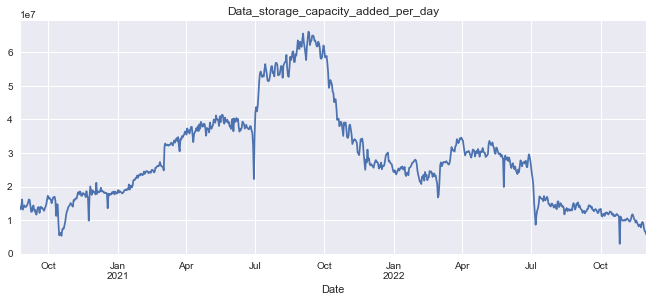

In [21]:
df = pd.read_csv('data/FilecoinGreenEnergyNew.csv')

df['Date'] = pd.to_datetime(df.Date)
df['year']  = df.Date.map(lambda x: str(x)[:4])
df['quarter'] = df.year.astype(str) + 'Q' + df.Date.dt.quarter.astype(str).values
df['month'] = df.Date.map(lambda x: str(x)[:7])
df.set_index('Date', inplace = True)

feats = [
 'Data_storage_capacity_added_per_day',
 'Energy_consumption_rate_estimate_bound',
 'Energy_intensity_estimate_bound',
 'FIL_Close',
 'FIL_Volume',
]
feat = 'Data_storage_capacity_added_per_day'
_ = df[feat].plot(figsize = (10,4), title = feat)

### 1. Make predictions

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


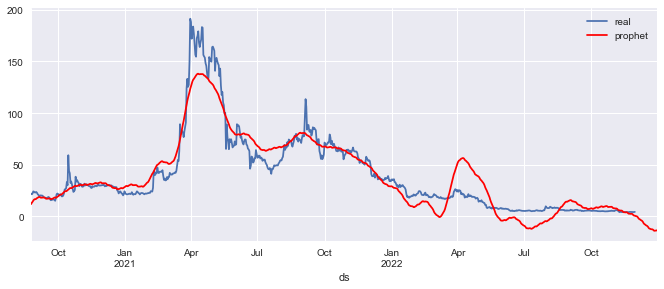

In [20]:
from prophet import Prophet

# 1) prepare dataframe
x = df[feat]
x = x.reset_index()
x.columns = ['ds','y']

# 2) build models (2 years of data, 1 year)

# train
x1 = x[-365:]
m = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=True,)
m.fit(x1)

# predict
t1 = 31
df1 = m.make_future_dataframe(periods=t1, freq='d')
df_out = m.predict(df1)



In [ ]:
# 4) plotting
_ = x.set_index('ds').plot(figsize = (10,4))
_ = df_out.set_index('ds')['yhat'].plot(color = 'red')
_ = _.legend(['real','prophet'])

### 2. Model description

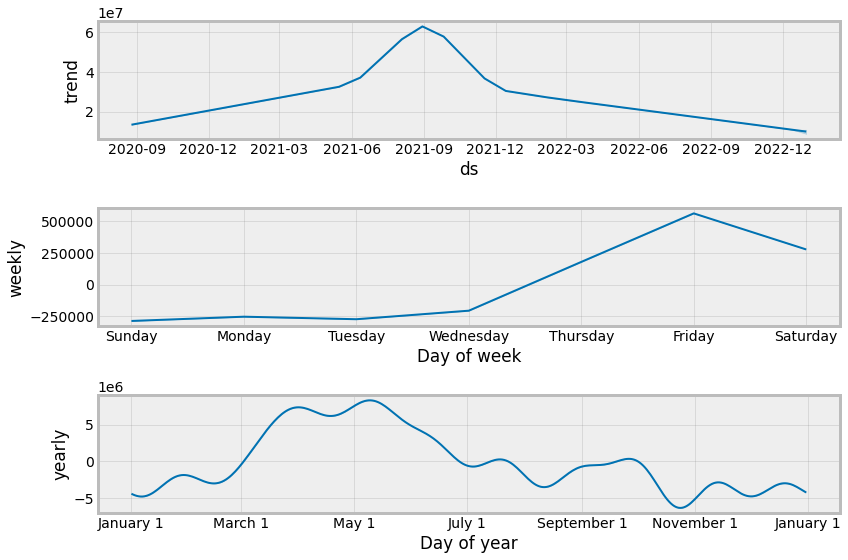

In [13]:
m.plot_components(df_out, figsize = (12,8))
plt.show()

### other

In [6]:
df_out

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-08-25,"11,399,842.01","6,402,690.68","15,453,212.88","11,399,842.01","11,399,842.01","-268,936.91","-268,936.91","-268,936.91","-268,936.91","-268,936.91","-268,936.91",0.00,0.00,0.00,"11,130,905.10"
1,2020-08-26,"11,459,778.74","6,863,958.22","15,567,792.16","11,459,778.74","11,459,778.74","-200,089.32","-200,089.32","-200,089.32","-200,089.32","-200,089.32","-200,089.32",0.00,0.00,0.00,"11,259,689.42"
2,2020-08-27,"11,519,715.48","7,334,496.89","16,178,382.67","11,519,715.48","11,519,715.48","176,888.06","176,888.06","176,888.06","176,888.06","176,888.06","176,888.06",0.00,0.00,0.00,"11,696,603.54"
3,2020-08-28,"11,579,652.21","7,982,667.55","16,514,276.73","11,579,652.21","11,579,652.21","559,963.66","559,963.66","559,963.66","559,963.66","559,963.66","559,963.66",0.00,0.00,0.00,"12,139,615.87"
4,2020-08-29,"11,639,588.95","7,544,422.37","16,348,331.30","11,639,588.95","11,639,588.95","275,115.29","275,115.29","275,115.29","275,115.29","275,115.29","275,115.29",0.00,0.00,0.00,"11,914,704.24"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,2022-12-27,"3,022,550.63","-1,692,972.70","7,517,975.22","2,286,574.99","4,071,114.39","-268,936.91","-268,936.91","-268,936.91","-268,936.91","-268,936.91","-268,936.91",0.00,0.00,0.00,"2,753,613.72"
855,2022-12-28,"2,916,454.99","-1,823,770.07","7,297,224.37","2,142,648.92","4,053,323.57","-200,089.32","-200,089.32","-200,089.32","-200,089.32","-200,089.32","-200,089.32",0.00,0.00,0.00,"2,716,365.67"
856,2022-12-29,"2,810,359.35","-1,780,281.21","7,760,369.60","1,984,251.58","4,014,470.60","176,888.06","176,888.06","176,888.06","176,888.06","176,888.06","176,888.06",0.00,0.00,0.00,"2,987,247.41"
857,2022-12-30,"2,704,263.71","-1,261,454.73","7,824,217.58","1,815,378.15","4,006,237.56","559,963.66","559,963.66","559,963.66","559,963.66","559,963.66","559,963.66",0.00,0.00,0.00,"3,264,227.37"


### Functions

In [8]:
# evaluation metrics
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
    }

# prophet model
from prophet import Prophet
def get_prophet(x, xv, shift_to_last = False):
    # 1) prepare dataframe
    df0 = x.reset_index()
    df0.columns = ['ds','y']
    
    # 2) build model
    m = Prophet(weekly_seasonality=True, daily_seasonality=False)
    m.fit(df0)

    # # 3) predict
    t1 = 50
    df1 = m.make_future_dataframe(periods=t1, freq='d')
    df_out = m.predict(df1).set_index('ds')['yhat'][xv.index]
    if shift_to_last:
        last_value = x[-1]
        first_value = df_out[0]
        delta = last_value - first_value
        return df_out + delta
    return df_out

# exponential smoothing model
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
def get_exponential(x, xv, shift_to_last = False):
    # 1) build model
    model = ExponentialSmoothing(x, trend="add", seasonal="add", seasonal_periods=7, 
                                 use_boxcox=False, damped = True, initialization_method = 'estimated')
    fit1 = model.fit()
    
    # 2) predict
    t1 = 50
    df_out = fit1.forecast(x.shape[0] + t1)
    df_out.index = list(x.index) + list(pd.date_range(x.index[-1], periods = t1+1, freq = 'd'))[1:]
    df_out = df_out[xv.index]
    if shift_to_last:
        last_value = x[-1]
        first_value = df_out[0]
        delta = last_value - first_value
        return df_out + delta    
    return df_out

### Models testing on different monthes

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


2022-01
(494,) (31,)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retva

,mae,mape,method
0,-1296069.161290,-0.049480,last_value
1,-12776448.517166,-0.496301,prophet
2,-6866492.985325,-0.263404,prophet_shifting
3,-1586959.491672,-0.060559,exponential
4,-1503541.336740,-0.057459,exponential_shifting


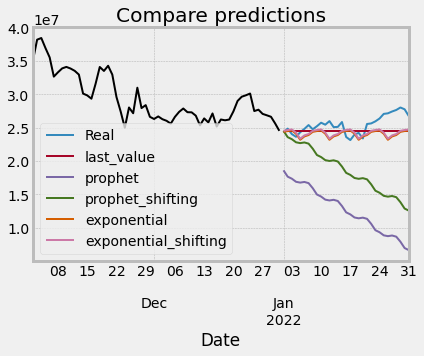

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


2022-02
(525,) (28,)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retva

,mae,mape,method
0,-3974200.000000,-0.181088,last_value
1,-10173074.678657,-0.445223,prophet
2,-2217504.685928,-0.099096,prophet_shifting
3,-4255425.906569,-0.193224,exponential
4,-4007028.504707,-0.182260,exponential_shifting


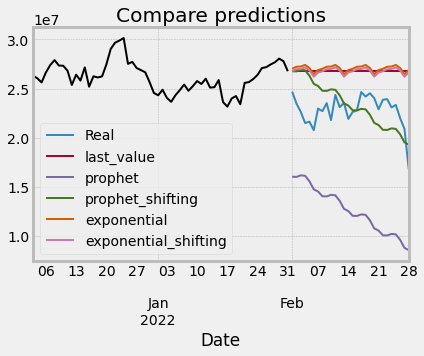

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


2022-03
(553,) (31,)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retva

,mae,mape,method
0,-12357943.741935,-0.412252,last_value
1,-11067370.975183,-0.365526,prophet
2,-13803621.873134,-0.458390,prophet_shifting
3,-11747829.661649,-0.390921,exponential
4,-12307247.622734,-0.410529,exponential_shifting


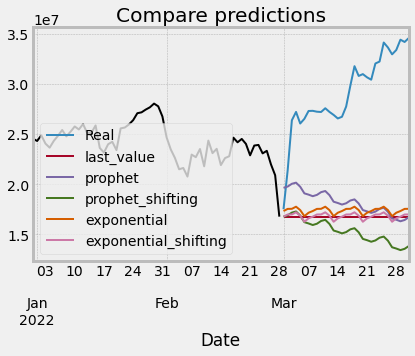

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


2022-04
(584,) (30,)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retva

,mae,mape,method
0,-4089949.866667,-0.135698,last_value
1,-3727728.170713,-0.121202,prophet
2,-3681295.817324,-0.122118,prophet_shifting
3,-3614587.865002,-0.120198,exponential
4,-4745565.551616,-0.157487,exponential_shifting


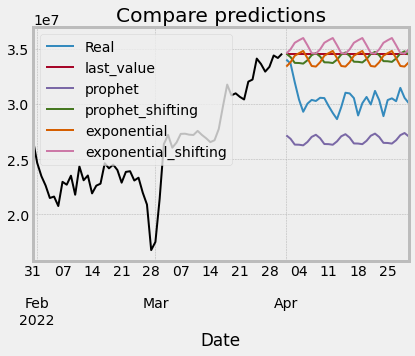

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


2022-05
(614,) (31,)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retva

,mae,mape,method
0,-1645760.000000,-0.059302,last_value
1,-2166189.123454,-0.079056,prophet
2,-2159968.785322,-0.078822,prophet_shifting
3,-1709686.672120,-0.060936,exponential
4,-1703771.624964,-0.059658,exponential_shifting


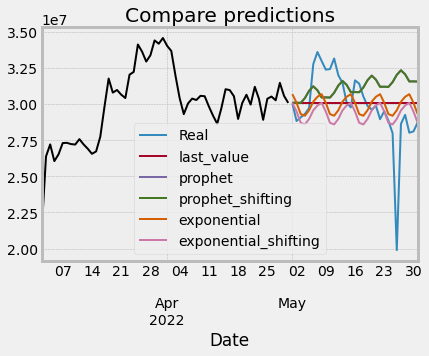

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


2022-06
(645,) (30,)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retva

,mae,mape,method
0,-2199251.200000,-0.085416,last_value
1,-5122587.077276,-0.195541,prophet
2,-2871581.231822,-0.110707,prophet_shifting
3,-2311794.851857,-0.089535,exponential
4,-2098210.566319,-0.081368,exponential_shifting


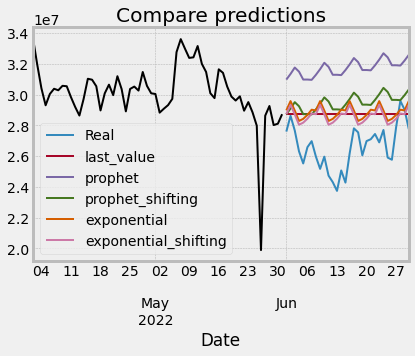

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


2022-07
(675,) (31,)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retva

,mae,mape,method
0,-11833639.225806,-0.819042,last_value
1,-14106854.067244,-0.968477,prophet
2,-11623387.295999,-0.805751,prophet_shifting
3,-11810546.070577,-0.816761,exponential
4,-12096679.367042,-0.835509,exponential_shifting


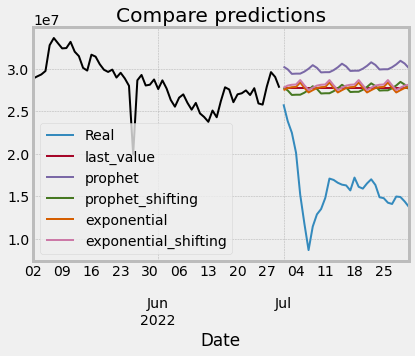

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


2022-08
(706,) (31,)


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization faile

,mae,mape,method
0,-757612.387097,-0.054578,last_value
1,-7479800.097501,-0.545827,prophet
2,-787619.195675,-0.055463,prophet_shifting
3,-790049.167277,-0.058059,exponential
4,-808398.630860,-0.059768,exponential_shifting


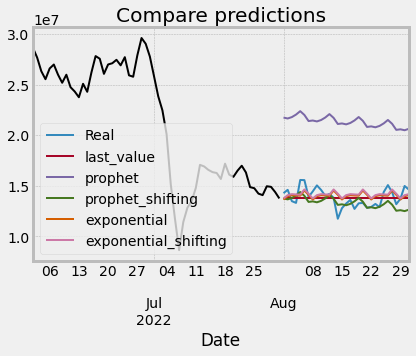

INFO:cmdstanpy:start chain 1


2022-09
(737,) (30,)


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,mae,mape,method
0,-1422378.666667,-0.110618,last_value
1,-3236514.330874,-0.246075,prophet
2,-3358995.132352,-0.255158,prophet_shifting
3,-1395105.175244,-0.108746,exponential
4,-1364394.911165,-0.106380,exponential_shifting


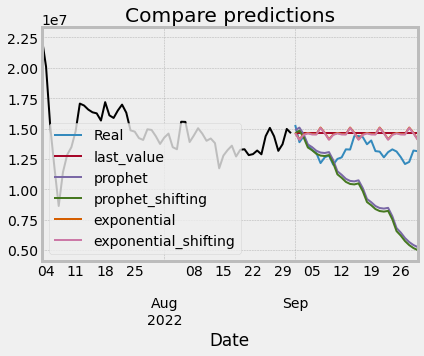

INFO:cmdstanpy:start chain 1


2022-10
(767,) (31,)


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,mae,mape,method
0,-1886608.516129,-0.251063,last_value
1,-17955045.101512,-1.729486,prophet
2,-11788436.624490,-1.142719,prophet_shifting
3,-1429443.464573,-0.203324,exponential
4,-1942034.492836,-0.252885,exponential_shifting


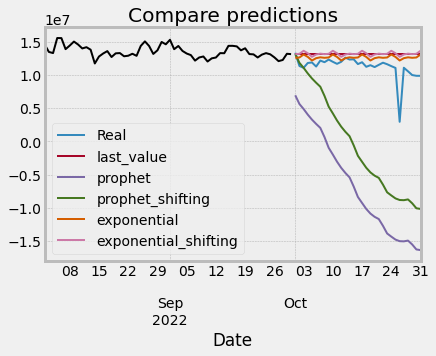

In [9]:
for t in range(1, 11):
    
    # 1) generate dataset
    test_month = f'2022-0{t}' if t < 10 else f'2022-{t}'
    print(test_month)
    x  = df[df.month < test_month][feat]
    xv = df[df.month == test_month][feat]#['2022-10-01':'2022-10-31']
    print(x.shape, xv.shape)

    # 2) models testing
    df_pred = xv.reset_index()
    df_pred.columns = ['Date', 'Real']
    df_pred.set_index('Date', inplace = True)

    out1 = list()
    out2 = list()

    # last value method
    x_pred = [x[-1]]*xv.shape[0]
    out1.append(ts_metrics(xv,x_pred))
    method = 'last_value'
    out2.append(method)
    df_pred[method] = x_pred

    # prophet model (without shifting to the last known value)
    x_pred = get_prophet(x, xv, shift_to_last=False)
    out1.append(ts_metrics(xv,x_pred))
    method = 'prophet'
    out2.append(method)
    df_pred[method] = x_pred

    # prophet model (with shifting to the last known value)
    x_pred = get_prophet(x, xv, shift_to_last=True)
    out1.append(ts_metrics(xv,x_pred))
    method = 'prophet_shifting'
    out2.append(method)
    df_pred[method] = x_pred

    # exponential smoothing model (without shifting to the last known value)
    x_pred = get_exponential(x, xv, shift_to_last=False)
    out1.append(ts_metrics(xv,x_pred))
    method = 'exponential'
    out2.append(method)
    df_pred[method] = x_pred

    # exponential smoothing model (with shifting to the last known value)
    x_pred = get_exponential(x, xv, shift_to_last=True)
    out1.append(ts_metrics(xv,x_pred))
    method = 'exponential_shifting'
    out2.append(method)
    df_pred[method] = x_pred

    # 3) get the results
    df_out = pd.DataFrame(out1)
    df_out = -df_out
    df_out['method'] = out2
    display(df_out.style.background_gradient(cmap='RdYlGn'))

    # 4) plottinf predictions
    ax = x[-60:].plot(color = 'black', title = 'Compare predictions', figsize = (6,4))
    _ = df_pred.plot(ax = ax)
    plt.show()

### Other

INFO:cmdstanpy:start chain 1


(828,) (828,)


INFO:cmdstanpy:finish chain 1


,mae,mape,method
0,-1893814.988646,-0.091488,prophet


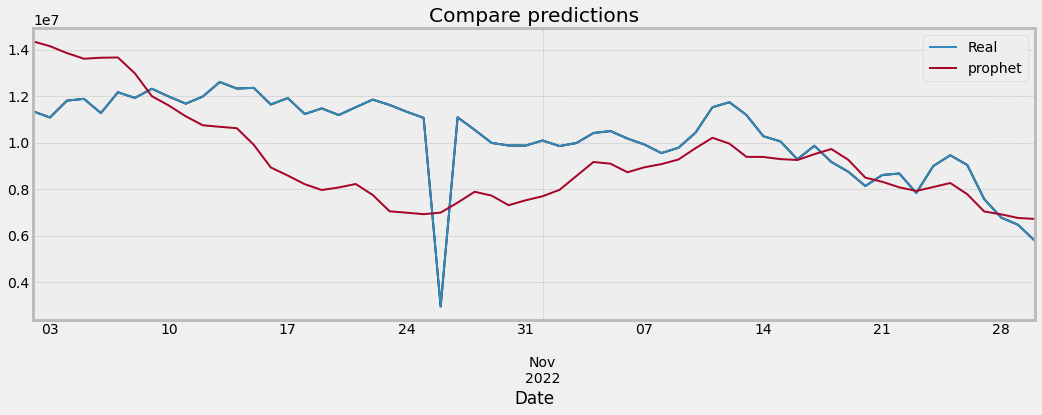

In [10]:
# 1) generate dataset
t = 12
test_month = f'2022-0{t}' if t < 10 else f'2022-{t}'
x  = df[df.month < test_month][feat]
xv = x
print(x.shape, xv.shape)

# 2) models testing
df_pred = xv.reset_index()
df_pred.columns = ['Date', 'Real']
df_pred.set_index('Date', inplace = True)

out1 = list()
out2 = list()

# prophet model (without shifting to the last known value)
x_pred = get_prophet(x, xv, shift_to_last=False)
out1.append(ts_metrics(xv,x_pred))
method = 'prophet'
out2.append(method)
df_pred[method] = x_pred

# 3) get the results
df_out = pd.DataFrame(out1)
df_out = -df_out
df_out['method'] = out2
display(df_out.style.background_gradient(cmap='RdYlGn'))

# 4) plottinf predictions
ax = x[-60:].plot(color = 'black', title = 'Compare predictions', figsize = (16,5))
_ = df_pred[-60:].plot(ax = ax)
plt.show()